To do:

- Try wilcoxon test to compare two distributions
- ~~Feature selection One-vs-many seems to give good seperation~~ This may not be the case -- implemented ``majority``, but the accuracy is not high
- Try to find the best scoring function

### Load Context

In [69]:
import os
import sys
import scipy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
os.chdir("/Users/kipnisal/DS/BiblicalScripts/bib-scripts/")
sys.path.append("/Users/kipnisal/DS/BiblicalScripts/bib-scripts/src")

params = catalog.load('parameters')

data = catalog.load("data_proc")
vocab = catalog.load("vocabulary")

known_authors = params['known_authors']

2022-05-24 21:58:03,585 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...
2022-05-24 21:58:03,599 - kedro.io.data_catalog - INFO - Loading data from `data_proc` (CSVDataSet)...
2022-05-24 21:58:03,793 - kedro.io.data_catalog - INFO - Loading data from `vocabulary` (CSVDataSet)...


In [73]:
data[data.author.isin(known_authors)].chapter.nunique()

86

In [83]:
df1 = pd.read_csv("/Users/kipnisal/DS/BiblicalScripts/bib-scripts/data/01_raw/reference_data_no_outliers.csv")
df2 = pd.read_csv("/Users/kipnisal/DS/BiblicalScripts/bib-scripts/data/01_raw/reference_data_no_outliers.csv")

True

In [3]:
import numpy as np
from scipy.stats import f as fdist
from scipy.stats import t as tdist
from scipy.stats import norm
from scipy.stats import ttest_ind as ttest
from scipy.stats import levene
from scipy.stats import bartlett

def discrepancy(cnt1, cnt2, **kwargs):
    
    disc_type = kwargs.get('test', 'HC')
    gamma = kwargs.get('gamma', .2)
    
    pvals = bin_allocation_test(cnt1, cnt2)
    mt = MultiTest(pvals)
    if disc_type == 'HC':
        hc,_ = mt.hc_star(gamma = gamma)
        return hc
    if disc_type == 'Fisher':
        return np.mean(-np.log(pvals))
    
    raise ValueError("Only HC-discrepancy is supported")

def merge_list_of_dataframes(lo_df):
    dfr = pd.DataFrame()
    for df in lo_df:
        dfr = dfr.append(df, ignore_index=True)
    return dfr
        
class CompareDocsRelativeResponse(object):
    """
    Upon call, this object need to return 
    HC discrepancy of two points
    
    Can use CompareDocs model but does not have to
    The issue is how to decide on a vocabulary
    
    """
    def __init__(self, compare_docs_model, discrepancy_type='HC'):
        self.cd_model = compare_docs_model
        self.disc_type = discrepancy_type
        

    def __call__(self, X1, X2):
        cnt1 = self.cd_model.count_words(merge_list_of_dataframes(X1)).n
        cnt2 = self.cd_model.count_words(merge_list_of_dataframes(X2)).n
        return discrepancy(cnt1, cnt2, disc_type=self.disc_type)
    

def test_f(scores0, scores1):
    def _sum_of_squares(scores):
            return np.sum((scores - np.mean(scores)) ** 2)
        
    ss0 = _sum_of_squares(scores0)
    ss1 = _sum_of_squares(scores1)
    fstat = ss1 / ss0
    return fstat, fdist.sf(ss1 / ss0, dfn=len(scores1)-1,dfd=len(scores0)-1)


def test_bartlett(scores0, scores1):
    return bartlett(scores0, scores1)


def test_t_2smp(scores0, scores1):
    return ttest(scores0, scores1)


def test_t(scores0, scores1):
    mu = np.mean(scores1[:-1])
    s = np.std(scores1[:-1], ddof=1)
    t = (scores1[-1] - mu) / ( s * np.sqrt(1 + 1/len(scores1[:-1]) ) )
    return t, tdist.sf(t, df=len(scores1) - 2) # one-sided


def test_wilcoxon(scores0, scores1):
    return scipy.stats.ranksums(scores0, scores1)


def test_perm(scores0, scores1):
    """
    Two-sample permutation test
    """
    return ttest(scores0, scores1, permutations=5000)


def test_linear(scores0, scores1):
    mu = np.mean(scores0)
    t = (scores1[-1] - mu) / np.std(scores0, ddof=1)
    return t, tdist.sf(t, df=len(scores0) - 1) # one-sided


def test_levene(scores0, scores1):
    return levene(scores0, scores1)

In [4]:
from twosample import bin_allocation_test
from multitest import MultiTest
from typing import List

        
class DivisibleClassClassifier(object):
    """
    ANOVA-based classification using a base
    response model. The relative response function is provided 
    in the fitting stage
    """
    
    def __init__(self):
        self._data = {}
        self.rr_func = None
        self.classes_ = []
        self.no_samples = {}
    
    def fit(self, relative_response_func, X: List, y: List):
        """
        
        Params:
            :relative_response_model: a model with method 'predict' 
            that returns the relative response of two datasets
            
            :X:   data
            :y:   labels
            
        """
        self.rr_func = relative_response_func
        self.no_samples = {}
        self._data = {}
        self.classes_ = list(np.unique(y))
        self.scores_ = {}
        for cls in self.classes_:
            X_cls = [X[i] for i,label in enumerate(y) if label == cls]
            self._data[cls] = X_cls
            self.scores_[cls] = self._within_corpus_disc(X_cls)
            self.no_samples[cls] = len(X_cls)
            
    def predict(self, x):
        probs = self.predict_proba(x)
        res = {}
        for k in probs:
            res[k] = -np.log(probs[k])
        return res
        
    def predict_table(self, x):
        df = pd.DataFrame()
        for cls in self.classes_:
            X_extended = self._data[cls] + [x]
            scores1 = self._within_corpus_disc(X_extended)
            scores0 = self.scores_[cls]
            stat, pval = self.test(scores0, scores1)
            df = df.append({'cls' : cls,
                            'scores1' : scores1,
                            'scores0' : scores0,
                            'n1' : len(scores0),
                            'n2' : len(scores1),
                            'stat' : stat, 
                            'pval' : pval
                           }, ignore_index=True)
        return df
        
    def predict_many(self, x):
        df = pd.DataFrame()
        for cls in self.classes_:
            X_extended = self._data[cls] + [x]
            scores1 = self._within_corpus_disc(X_extended)
            scores0 = self.scores_[cls]
            res = self.many_tests(scores0, scores1)
            dfr = dict({'cls' : cls,
                   'n1' : len(scores0),
                   'n2' : len(scores1),
                    **res})
            df = df.append(dfr, ignore_index=True)
        return df
            
    def predict_proba(self, x):
        """
        Returns class probabilities
        
        Probabilites are obtained via f-test:
        SS of each class with x included versue SS without x
        """
        df = self.predict_table(x)
        probs = dict(zip(df.cls, df.pval))
        return probs
    
    
    def test(self, scores0, scores1):
        return test_t(scores0, scores1)
    
    
    def many_tests(self, scores0, scores1):
        return dict(
        raw = scores1[-1], 
        pval_t = test_t(scores0, scores1)[1],
        pval_f = test_f(scores0, scores1)[1],
        pval_bartlett = test_bartlett(scores0, scores1)[1],
        pval_2smp = test_t_2smp(scores0, scores1)[1],
        pval_tLDA = test_linear(scores0, scores1)[1],
        pval_levene = test_levene(scores0, scores1)[1],
        pval_wilcox = test_wilcoxon(scores0, scores1).pvalue,
        pval_2smp_perm = test_perm(scores0, scores1)[1]
        )
        
        
    def _within_corpus_disc(self, X: List):
        """
        Find relative response of each element in X compared to the other elements.
        
        Params:
            :X:  data
        
        Returns:
            :scores:     relative response
        """
        scores = np.zeros(len(X))
        for i,x in enumerate(X):
            scores[i] = self.rr_func([x], [X[j] for j,_ in enumerate(X) if j != i])
        return scores
        

In [27]:
from biblical_scripts.pipelines.sim.nodes import (
    build_model, model_predict, _prepare_data)
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

In [6]:
data = _prepare_data(data[data.to_report])
data_known = data[data.author.isin(known_authors)]
lo_docs = data_known.doc_id.unique()

2022-05-23 08:18:28,481 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [37]:
def arrange_training_data(data):
    X = []
    y = []
    lo_authors = data.author.unique()
    for auth in lo_authors:
        ds_auth = data[data.author == auth]
        lo_docs = ds_auth.doc_id.unique()
        Xauth = [c[1] for c in ds_auth.groupby('doc_id')]
        X += Xauth
        y += [auth] * len(Xauth)
    return X, y


n_splits = 13
shuffle = True
n_repeats = 10


train_doc_names = data_known.filter(['doc_id', 'author']).drop_duplicates().doc_id
train_doc_authors = data_known.filter(['doc_id', 'author']).drop_duplicates().author
#kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)

df_res = pd.DataFrame()

acc = 0
for train_index, test_index in tqdm(kf.split(train_doc_names, train_doc_authors)):
    acc += 1
    test_docs = train_doc_names.iloc[test_index]
    ds1 = data_known[data_known.doc_id.isin(test_docs)] # test docs data
    data_train = data_known.drop(ds1.index) # drop whatever is in test
    
    md, vocab = build_model(data_train, vocab, params['model'])
    cdrr = CompareDocsRelativeResponse(md)
    
    X, y = arrange_training_data(data_train)
    anova_cls = DivisibleClassClassifier()
    anova_cls.fit(cdrr, X, y)
    
    for doc in test_docs:
        ds11 = data_known[data_known.doc_id == doc]
        res = anova_cls.predict_many(ds11)
        res['doc_tested'] = doc
        res['len'] = len(ds11)
        res['repeat'] = acc // n_splits
        df_res = df_res.append(res, ignore_index=True)


0it [00:00, ?it/s]

2022-05-23 09:50:08,154 - root - INFO - Building CompareDocs model using 46 documents. 


1it [00:08,  8.41s/it]

2022-05-23 09:50:16,558 - root - INFO - Building CompareDocs model using 46 documents. 


2it [00:16,  8.21s/it]

2022-05-23 09:50:24,636 - root - INFO - Building CompareDocs model using 46 documents. 


3it [00:24,  8.27s/it]

2022-05-23 09:50:32,975 - root - INFO - Building CompareDocs model using 46 documents. 


4it [00:33,  8.29s/it]

2022-05-23 09:50:41,282 - root - INFO - Building CompareDocs model using 46 documents. 


5it [00:41,  8.25s/it]

2022-05-23 09:50:49,477 - root - INFO - Building CompareDocs model using 46 documents. 


6it [00:49,  8.35s/it]

2022-05-23 09:50:58,013 - root - INFO - Building CompareDocs model using 46 documents. 


7it [00:57,  8.26s/it]

2022-05-23 09:51:06,080 - root - INFO - Building CompareDocs model using 46 documents. 


8it [01:05,  8.19s/it]

2022-05-23 09:51:14,133 - root - INFO - Building CompareDocs model using 46 documents. 


9it [01:14,  8.19s/it]

2022-05-23 09:51:22,305 - root - INFO - Building CompareDocs model using 46 documents. 


10it [01:22,  8.18s/it]

2022-05-23 09:51:30,474 - root - INFO - Building CompareDocs model using 46 documents. 


11it [01:30,  8.23s/it]

2022-05-23 09:51:38,823 - root - INFO - Building CompareDocs model using 47 documents. 


12it [01:37,  7.95s/it]

2022-05-23 09:51:46,124 - root - INFO - Building CompareDocs model using 47 documents. 


13it [01:44,  7.64s/it]

2022-05-23 09:51:53,056 - root - INFO - Building CompareDocs model using 46 documents. 


14it [01:53,  7.85s/it]

2022-05-23 09:52:01,392 - root - INFO - Building CompareDocs model using 46 documents. 


15it [02:01,  7.94s/it]

2022-05-23 09:52:09,533 - root - INFO - Building CompareDocs model using 46 documents. 


16it [02:09,  8.01s/it]

2022-05-23 09:52:17,709 - root - INFO - Building CompareDocs model using 46 documents. 


17it [02:17,  8.05s/it]

2022-05-23 09:52:25,865 - root - INFO - Building CompareDocs model using 46 documents. 


18it [02:25,  8.11s/it]

2022-05-23 09:52:34,108 - root - INFO - Building CompareDocs model using 46 documents. 


19it [02:34,  8.23s/it]

2022-05-23 09:52:42,600 - root - INFO - Building CompareDocs model using 46 documents. 


20it [02:42,  8.24s/it]

2022-05-23 09:52:50,860 - root - INFO - Building CompareDocs model using 46 documents. 


21it [02:51,  8.36s/it]

2022-05-23 09:52:59,525 - root - INFO - Building CompareDocs model using 46 documents. 


22it [02:59,  8.39s/it]

2022-05-23 09:53:07,976 - root - INFO - Building CompareDocs model using 46 documents. 


23it [03:08,  8.45s/it]

2022-05-23 09:53:16,566 - root - INFO - Building CompareDocs model using 46 documents. 


24it [03:16,  8.45s/it]

2022-05-23 09:53:25,024 - root - INFO - Building CompareDocs model using 47 documents. 


25it [03:23,  7.95s/it]

2022-05-23 09:53:31,808 - root - INFO - Building CompareDocs model using 47 documents. 


26it [03:30,  7.68s/it]

2022-05-23 09:53:38,841 - root - INFO - Building CompareDocs model using 46 documents. 


27it [03:38,  7.83s/it]

2022-05-23 09:53:47,041 - root - INFO - Building CompareDocs model using 46 documents. 


28it [03:47,  7.98s/it]

2022-05-23 09:53:55,369 - root - INFO - Building CompareDocs model using 46 documents. 


29it [03:55,  8.19s/it]

2022-05-23 09:54:04,029 - root - INFO - Building CompareDocs model using 46 documents. 


30it [04:04,  8.24s/it]

2022-05-23 09:54:12,401 - root - INFO - Building CompareDocs model using 46 documents. 


31it [04:12,  8.18s/it]

2022-05-23 09:54:20,430 - root - INFO - Building CompareDocs model using 46 documents. 


32it [04:20,  8.22s/it]

2022-05-23 09:54:28,747 - root - INFO - Building CompareDocs model using 46 documents. 


33it [04:29,  8.37s/it]

2022-05-23 09:54:37,457 - root - INFO - Building CompareDocs model using 46 documents. 


34it [04:37,  8.33s/it]

2022-05-23 09:54:45,693 - root - INFO - Building CompareDocs model using 46 documents. 


35it [04:45,  8.30s/it]

2022-05-23 09:54:53,923 - root - INFO - Building CompareDocs model using 46 documents. 


36it [04:54,  8.44s/it]

2022-05-23 09:55:02,684 - root - INFO - Building CompareDocs model using 46 documents. 


37it [05:03,  8.52s/it]

2022-05-23 09:55:11,402 - root - INFO - Building CompareDocs model using 47 documents. 


38it [05:10,  8.19s/it]

2022-05-23 09:55:18,809 - root - INFO - Building CompareDocs model using 47 documents. 


39it [05:17,  7.88s/it]

2022-05-23 09:55:25,982 - root - INFO - Building CompareDocs model using 46 documents. 


40it [05:26,  8.05s/it]

2022-05-23 09:55:34,437 - root - INFO - Building CompareDocs model using 46 documents. 


41it [05:35,  8.28s/it]

2022-05-23 09:55:43,239 - root - INFO - Building CompareDocs model using 46 documents. 


42it [05:44,  8.47s/it]

2022-05-23 09:55:52,151 - root - INFO - Building CompareDocs model using 46 documents. 


43it [05:52,  8.62s/it]

2022-05-23 09:56:01,137 - root - INFO - Building CompareDocs model using 46 documents. 


44it [06:01,  8.60s/it]

2022-05-23 09:56:09,670 - root - INFO - Building CompareDocs model using 46 documents. 


45it [06:10,  8.70s/it]

2022-05-23 09:56:18,603 - root - INFO - Building CompareDocs model using 46 documents. 


46it [06:18,  8.61s/it]

2022-05-23 09:56:27,006 - root - INFO - Building CompareDocs model using 46 documents. 


47it [06:27,  8.61s/it]

2022-05-23 09:56:35,624 - root - INFO - Building CompareDocs model using 46 documents. 


48it [06:36,  8.62s/it]

2022-05-23 09:56:44,247 - root - INFO - Building CompareDocs model using 46 documents. 


49it [06:44,  8.65s/it]

2022-05-23 09:56:52,993 - root - INFO - Building CompareDocs model using 46 documents. 


50it [06:53,  8.55s/it]

2022-05-23 09:57:01,288 - root - INFO - Building CompareDocs model using 47 documents. 


51it [07:00,  8.12s/it]

2022-05-23 09:57:08,421 - root - INFO - Building CompareDocs model using 47 documents. 


52it [07:07,  7.88s/it]

2022-05-23 09:57:15,739 - root - INFO - Building CompareDocs model using 46 documents. 


53it [07:16,  8.11s/it]

2022-05-23 09:57:24,384 - root - INFO - Building CompareDocs model using 46 documents. 


54it [07:24,  8.21s/it]

2022-05-23 09:57:32,827 - root - INFO - Building CompareDocs model using 46 documents. 


55it [07:33,  8.27s/it]

2022-05-23 09:57:41,251 - root - INFO - Building CompareDocs model using 46 documents. 


56it [07:41,  8.30s/it]

2022-05-23 09:57:49,595 - root - INFO - Building CompareDocs model using 46 documents. 


57it [07:49,  8.36s/it]

2022-05-23 09:57:58,100 - root - INFO - Building CompareDocs model using 46 documents. 


58it [07:58,  8.41s/it]

2022-05-23 09:58:06,621 - root - INFO - Building CompareDocs model using 46 documents. 


59it [08:06,  8.41s/it]

2022-05-23 09:58:15,023 - root - INFO - Building CompareDocs model using 46 documents. 


60it [08:15,  8.41s/it]

2022-05-23 09:58:23,430 - root - INFO - Building CompareDocs model using 46 documents. 


61it [08:23,  8.34s/it]

2022-05-23 09:58:31,620 - root - INFO - Building CompareDocs model using 46 documents. 


62it [08:31,  8.27s/it]

2022-05-23 09:58:39,718 - root - INFO - Building CompareDocs model using 46 documents. 


63it [08:40,  8.49s/it]

2022-05-23 09:58:48,712 - root - INFO - Building CompareDocs model using 47 documents. 


64it [08:47,  7.99s/it]

2022-05-23 09:58:55,548 - root - INFO - Building CompareDocs model using 47 documents. 


65it [08:54,  7.70s/it]

2022-05-23 09:59:02,580 - root - INFO - Building CompareDocs model using 46 documents. 


66it [09:02,  7.83s/it]

2022-05-23 09:59:10,719 - root - INFO - Building CompareDocs model using 46 documents. 


67it [09:10,  7.93s/it]

2022-05-23 09:59:18,889 - root - INFO - Building CompareDocs model using 46 documents. 


68it [09:19,  8.05s/it]

2022-05-23 09:59:27,193 - root - INFO - Building CompareDocs model using 46 documents. 


69it [09:27,  8.27s/it]

2022-05-23 09:59:35,981 - root - INFO - Building CompareDocs model using 46 documents. 


70it [09:36,  8.37s/it]

2022-05-23 09:59:44,572 - root - INFO - Building CompareDocs model using 46 documents. 


71it [09:44,  8.34s/it]

2022-05-23 09:59:52,867 - root - INFO - Building CompareDocs model using 46 documents. 


72it [09:53,  8.42s/it]

2022-05-23 10:00:01,449 - root - INFO - Building CompareDocs model using 46 documents. 


73it [10:01,  8.46s/it]

2022-05-23 10:00:10,025 - root - INFO - Building CompareDocs model using 46 documents. 


74it [10:10,  8.48s/it]

2022-05-23 10:00:18,531 - root - INFO - Building CompareDocs model using 46 documents. 


75it [10:18,  8.48s/it]

2022-05-23 10:00:27,012 - root - INFO - Building CompareDocs model using 46 documents. 


76it [10:27,  8.61s/it]

2022-05-23 10:00:35,922 - root - INFO - Building CompareDocs model using 47 documents. 


77it [10:34,  8.13s/it]

2022-05-23 10:00:42,929 - root - INFO - Building CompareDocs model using 47 documents. 


78it [10:41,  7.81s/it]

2022-05-23 10:00:49,998 - root - INFO - Building CompareDocs model using 46 documents. 


79it [10:50,  8.10s/it]

2022-05-23 10:00:58,760 - root - INFO - Building CompareDocs model using 46 documents. 


80it [10:59,  8.31s/it]

2022-05-23 10:01:07,555 - root - INFO - Building CompareDocs model using 46 documents. 


81it [11:08,  8.41s/it]

2022-05-23 10:01:16,217 - root - INFO - Building CompareDocs model using 46 documents. 


82it [11:16,  8.51s/it]

2022-05-23 10:01:24,969 - root - INFO - Building CompareDocs model using 46 documents. 


83it [11:25,  8.50s/it]

2022-05-23 10:01:33,441 - root - INFO - Building CompareDocs model using 46 documents. 


84it [11:34,  8.60s/it]

2022-05-23 10:01:42,258 - root - INFO - Building CompareDocs model using 46 documents. 


85it [11:42,  8.61s/it]

2022-05-23 10:01:50,897 - root - INFO - Building CompareDocs model using 46 documents. 


86it [11:51,  8.55s/it]

2022-05-23 10:01:59,310 - root - INFO - Building CompareDocs model using 46 documents. 


87it [11:59,  8.59s/it]

2022-05-23 10:02:08,000 - root - INFO - Building CompareDocs model using 46 documents. 


88it [12:08,  8.66s/it]

2022-05-23 10:02:16,823 - root - INFO - Building CompareDocs model using 46 documents. 


89it [12:17,  8.65s/it]

2022-05-23 10:02:25,454 - root - INFO - Building CompareDocs model using 47 documents. 


90it [12:24,  8.25s/it]

2022-05-23 10:02:32,752 - root - INFO - Building CompareDocs model using 47 documents. 


91it [12:31,  7.94s/it]

2022-05-23 10:02:39,966 - root - INFO - Building CompareDocs model using 46 documents. 


92it [12:40,  8.10s/it]

2022-05-23 10:02:48,433 - root - INFO - Building CompareDocs model using 46 documents. 


93it [12:48,  8.26s/it]

2022-05-23 10:02:57,065 - root - INFO - Building CompareDocs model using 46 documents. 


94it [12:57,  8.33s/it]

2022-05-23 10:03:05,553 - root - INFO - Building CompareDocs model using 46 documents. 


95it [13:05,  8.37s/it]

2022-05-23 10:03:14,037 - root - INFO - Building CompareDocs model using 46 documents. 


96it [13:14,  8.40s/it]

2022-05-23 10:03:22,498 - root - INFO - Building CompareDocs model using 46 documents. 


97it [13:22,  8.37s/it]

2022-05-23 10:03:30,787 - root - INFO - Building CompareDocs model using 46 documents. 


98it [13:31,  8.40s/it]

2022-05-23 10:03:39,274 - root - INFO - Building CompareDocs model using 46 documents. 


99it [13:39,  8.49s/it]

2022-05-23 10:03:47,957 - root - INFO - Building CompareDocs model using 46 documents. 


100it [13:48,  8.49s/it]

2022-05-23 10:03:56,442 - root - INFO - Building CompareDocs model using 46 documents. 


101it [13:56,  8.45s/it]

2022-05-23 10:04:04,812 - root - INFO - Building CompareDocs model using 46 documents. 


102it [14:04,  8.37s/it]

2022-05-23 10:04:12,978 - root - INFO - Building CompareDocs model using 47 documents. 


103it [14:11,  7.97s/it]

2022-05-23 10:04:20,014 - root - INFO - Building CompareDocs model using 47 documents. 


104it [14:18,  7.62s/it]

2022-05-23 10:04:26,815 - root - INFO - Building CompareDocs model using 46 documents. 


105it [14:27,  7.87s/it]

2022-05-23 10:04:35,288 - root - INFO - Building CompareDocs model using 46 documents. 


106it [14:35,  8.06s/it]

2022-05-23 10:04:43,792 - root - INFO - Building CompareDocs model using 46 documents. 


107it [14:43,  8.10s/it]

2022-05-23 10:04:51,970 - root - INFO - Building CompareDocs model using 46 documents. 


108it [14:52,  8.26s/it]

2022-05-23 10:05:00,621 - root - INFO - Building CompareDocs model using 46 documents. 


109it [15:00,  8.31s/it]

2022-05-23 10:05:09,027 - root - INFO - Building CompareDocs model using 46 documents. 


110it [15:09,  8.40s/it]

2022-05-23 10:05:17,651 - root - INFO - Building CompareDocs model using 46 documents. 


111it [15:17,  8.42s/it]

2022-05-23 10:05:26,126 - root - INFO - Building CompareDocs model using 46 documents. 


112it [15:26,  8.38s/it]

2022-05-23 10:05:34,419 - root - INFO - Building CompareDocs model using 46 documents. 


113it [15:34,  8.35s/it]

2022-05-23 10:05:42,701 - root - INFO - Building CompareDocs model using 46 documents. 


114it [15:43,  8.41s/it]

2022-05-23 10:05:51,247 - root - INFO - Building CompareDocs model using 46 documents. 


115it [15:51,  8.37s/it]

2022-05-23 10:05:59,528 - root - INFO - Building CompareDocs model using 47 documents. 


116it [15:58,  8.02s/it]

2022-05-23 10:06:06,711 - root - INFO - Building CompareDocs model using 47 documents. 


117it [16:05,  7.68s/it]

2022-05-23 10:06:13,607 - root - INFO - Building CompareDocs model using 46 documents. 


118it [16:13,  7.89s/it]

2022-05-23 10:06:21,972 - root - INFO - Building CompareDocs model using 46 documents. 


119it [16:22,  8.01s/it]

2022-05-23 10:06:30,280 - root - INFO - Building CompareDocs model using 46 documents. 


120it [16:30,  8.17s/it]

2022-05-23 10:06:38,834 - root - INFO - Building CompareDocs model using 46 documents. 


121it [16:39,  8.31s/it]

2022-05-23 10:06:47,464 - root - INFO - Building CompareDocs model using 46 documents. 


122it [16:47,  8.32s/it]

2022-05-23 10:06:55,798 - root - INFO - Building CompareDocs model using 46 documents. 


123it [16:56,  8.34s/it]

2022-05-23 10:07:04,197 - root - INFO - Building CompareDocs model using 46 documents. 


124it [17:04,  8.46s/it]

2022-05-23 10:07:12,933 - root - INFO - Building CompareDocs model using 46 documents. 


125it [17:13,  8.49s/it]

2022-05-23 10:07:21,492 - root - INFO - Building CompareDocs model using 46 documents. 


126it [17:21,  8.47s/it]

2022-05-23 10:07:29,923 - root - INFO - Building CompareDocs model using 46 documents. 


127it [17:30,  8.46s/it]

2022-05-23 10:07:38,342 - root - INFO - Building CompareDocs model using 46 documents. 


128it [17:38,  8.46s/it]

2022-05-23 10:07:46,805 - root - INFO - Building CompareDocs model using 47 documents. 


129it [17:45,  7.97s/it]

2022-05-23 10:07:53,637 - root - INFO - Building CompareDocs model using 47 documents. 


130it [17:52,  8.25s/it]


In [68]:
df_res.loc[: ,'true_class'] = df_res.doc_tested.apply(lambda x : x.split('|')[0])
#df_res.loc[:, 'neg_raw'] = -df_res['raw']

for value in df_res.columns[df_res.columns.str.contains(r'pval|neg_raw|avg')]:        
    idx = df_res.groupby('doc_tested')[value].idxmax(axis=1)
    acc = np.mean(df_res.loc[idx, 'cls'] == df_res.loc[idx, 'true_class']) 
    print(f"Accuracy with {value} = {acc}")
    #std = np.std(df_res.loc[idx, 'cls'] == df_res.loc[idx, 'true_class']) 
    #print(f"Std with {value} = {std}")
    #df_res['predicted_class'] = df_res[['Dtr', 'DtrH', 'P']].idxmin(axis=1)
    #print("Accuracy: ", np.mean(df_res.predicted_class == df_res.true_class))

Accuracy with pval_2smp = 0.64
Accuracy with pval_2smp_perm = 0.64
Accuracy with pval_bartlett = 0.48
Accuracy with pval_f = 0.66
Accuracy with pval_levene = 0.5
Accuracy with pval_t = 0.86
Accuracy with pval_tLDA = 0.84
Accuracy with pval_wilcox = 0.78


In [63]:
df_res.loc[: ,'true_class'] = df_res.doc_tested.apply(lambda x : x.split('|')[0])
#df_res.loc[:, 'neg_raw'] = -df_res['raw']

df_res_cv = pd.DataFrame()
for c in df_res.groupby('repeat'):
    for value in c[1].columns[c[1].columns.str.contains(r'pval|neg_raw|avg')]:        
        idx = c[1].groupby('doc_tested')[value].idxmax(axis=1)
        acc = np.mean(c[1].loc[idx, 'cls'] == c[1].loc[idx, 'true_class']) 
        #print(f"Accuracy with {value} = {acc}")
        df_res_cv = df_res_cv.append(
            {'value': value,
             'acc': acc,
             'repeat': c[0]
        }, ignore_index=True)
        #df_res['predicted_class'] = df_res[['Dtr', 'DtrH', 'P']].idxmin(axis=1)
        #print("Accuracy: ", np.mean(df_res.predicted_class == df_res.true_class))
value = 'pval_t'
print("Mean = ", df_res_cv[df_res_cv['value'] == value].acc.mean())
print("Std = ", df_res_cv[df_res_cv['value'] == value].acc.std())

Mean =  0.8578739522888459
Std =  0.052353878111379995


In [62]:
for value in df_res.columns[df_res.columns.str.contains(r'pval|neg_raw|avg')]:
    mean = df_res_cv[df_res_cv['value'] == value].acc.mean()
    std = df_res_cv[df_res_cv['value'] == value].acc.std()
    print(np.sqrt((1-mean) * mean / len(df_res_cv[df_res_cv['value'] == value])) / 2)
    print(std)
    print('\n')


0.07324759196498103
0.04144164135848568


0.07324611595841671
0.042103990215439896


0.07499804368139859
0.15863078611095574


0.06815828152767664
0.10541747351022016


0.07497945559702364
0.11348466864218883


0.05264077107086744
0.052353878111379995


0.05293798222957187
0.05298422977831183


0.07056875642928004
0.059513938492178585




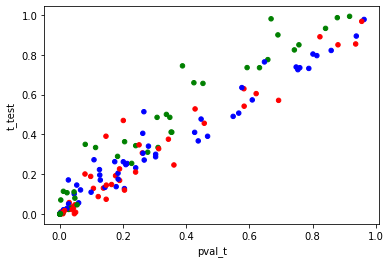

<ipython-input-66-9d991b5a82ca>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<ipython-input-66-9d991b5a82ca>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,cls,n1,n2,doc_tested,raw,true_class,pval_tLDA,pval_t,t-score,t_test,"('value', 'mean')","('value', 'count')"
15,Dtr,8.0,9.0,Dtr|Deut.19,2.169542,Dtr,0.263881,0.201162,0.077118,0.470344,1.169069,8
90,Dtr,7.0,8.0,Dtr|Deut.15,2.744395,Dtr,0.046568,0.080018,0.891548,0.201120,1.078535,8
93,Dtr,7.0,8.0,Dtr|Deut.16,1.958934,Dtr,0.157389,0.146356,0.287108,0.391171,1.192409,8


In [66]:
# compare with previous evaluation

df = df_res.merge(probs.rename(columns={'corpus' : 'cls'}), on=['doc_tested', 'cls'])
df['t_test'] = np.exp(-df['t_test'])
df1 = df.filter(['cls', 'n1', 'n2', 'doc_tested', 'raw', 'len', 'true_class', 'pval_tLDA', 'pval_t', 't-score', 't_test', "('value', 'mean')", "('value', 'count')"])

color_dic = {'Dtr' : 'red', 'DtrH' : 'green', 'P' : 'blue'}
colors = [color_dic[a] for a in df1['cls'].values]

df1.plot.scatter(x='pval_t', y='t_test', color=colors)
plt.show()

df1[df1.cls == 'Dtr'][df1.true_class == 'Dtr'][df1.t_test/df1.pval_t > 1.1]

In [15]:
dfr = df_res.filter(regex=r'(pval_|raw|cls|doc_tested|true_class|avg)').pivot(columns = 'cls', index='doc_tested')

In [16]:
color_dic = {'Dtr' : 'red', 'DtrH' : 'green', 'P' : 'blue'}
colors = [color_dic[a] for a in dfr['true_class']['P'].values]

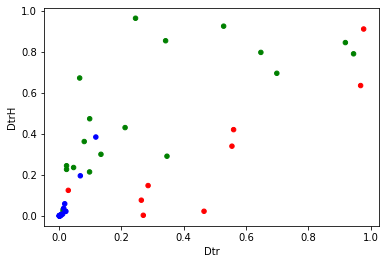

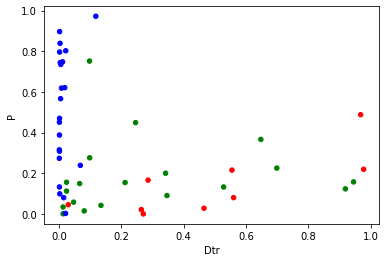

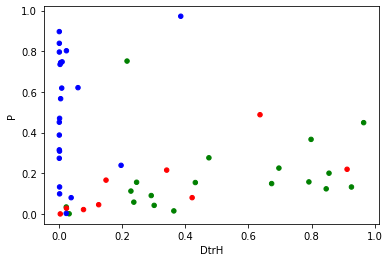

In [17]:
value = 'pval_tLDA'

for cls1 in ['Dtr', 'DtrH', 'P'] :
    for cls2 in ['Dtr', 'DtrH', 'P']:
        if cls1 < cls2:
            dfr.plot.scatter(x=(value, cls1), y=(value, cls2),
                             color=colors)
            #plt.xlim((0,0.1))
            #plt.ylim((0,0.1))
            plt.xlabel(cls1)
            plt.ylabel(cls2)
            plt.show()

In [26]:
train_doc_names = data_known.filter(['doc_id', 'author']).drop_duplicates()
train_doc_authors = data_known.filter(['doc_id', 'author']).drop_duplicates().author
kf = RepeatedStratifiedKFold(n_splits=13, n_repeats=2)
for train_index, test_index in tqdm(kf.split(train_doc_names, train_doc_authors)):
    print(test_index)

0it [00:00, ?it/s]/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=13.
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=13.
26it [00:00, 4842.66it/s]

[ 0 20 27 45]
[ 8  9 23 36]
[ 1 16 30 31]
[ 2 26 39 48]
[ 3 18 32 35]
[ 5 22 44 49]
[ 4 11 37 43]
[ 6 21 42 47]
[ 7 24 28 46]
[10 19 33 38]
[12 15 34 40]
[13 17 29]
[14 25 41]
[ 1 13 18 29]
[ 4 11 21 43]
[ 6 23 28 38]
[ 3 25 33 48]
[ 5 16 30 35]
[ 2 15 42 44]
[ 7  9 46 49]
[ 0 20 31 41]
[ 8 12 34 36]
[19 24 37 40]
[14 26 32 39]
[10 27 45]
[17 22 47]


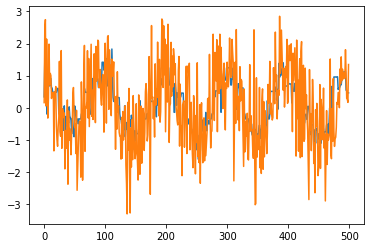

In [185]:
plt.plot(y_preds)
plt.plot(y_true)